<a href="https://colab.research.google.com/github/hwl20/Projects/blob/main/Personal_Projects/Used%20Car%20Prediction/UsedCarGoogleColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project dataset: https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho?select=Car+details+v3.csv
Date retrieved: 2021-07-20

Business problem: 

    We want to create a model that is able to accurately predict the value of a car. 
    This will allow car buyers to better evaluate the true value of a car such that they are not overpaying based on certain car metrics.
    Also it will allow sellers to better estimate the price they want to list their car especially if they want to ensure they are able to sell their car.
    This has very practical use cases for car buying/selling platforms to provide price suggestion when users list cars on their platforms
    Higher turnover rate will mean more PROFIT for platforms who earn comission from a resale of a car and happy customers which help customer retention as well
        
Dataset details:

-This dataset contains information about used cars based in India last recorded on June 2020

-Preliminary column desription and personal thoughts:

    1. name - name and model of vehicle
    2. year - car manufacture date, older cars should have relatively lower value due to depreciation
    3. selling_price - dependent variable that we are looking to build a model that can accurately predict this
    4. km_driven - indicates the distance that has already been driven, which may imply the current condition of the car
    5. fuel - type of fuel used, diesel cars are generally cheaper than petrol cars
    6. seller_type - Individual sellers should be cheaper than Dealer who would want to collcect a comission
    7. transmission - Manual or Auto, not clear how would this affect price yet
    8. owner - Number of owners a particular car had, more owners car generally have lower prices as it may suggest that there might be some issues in the car (psychological factor)
    9. mileage - fuel efficency, higher efficiency could potentially fetch higher prices
    10. engine - Engine capacity, higher engine capacity should suggest higher selling price
    11. max_power - Power of engine, higher power should suggest higher selling price
    12. torque - Engine rotational force, higher torque should suggest higher selling price
    13. seats- Seats of car, more seats generally corresponds to higher selling price

In here we will follow the data science framework of working with data:

  1. Retrieving data - Kindly done so from kaggle
  
  2. Data Cleaning
  
  3. Exploratory Data Analysis to get a better understanding of data
  
  4. Feature selection 
  
  5. Model Building


# **Importing Packages**


In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import math

# **Retrieving data**

In [151]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [152]:
df = pd.read_csv("/content/drive/MyDrive/Car details v3.csv")
print("Shape of dataframe: ", df.shape)
print("\nFirst 5 rows: ", df.head())

Shape of dataframe:  (8128, 13)

First 5 rows:                             name  year  ...                    torque  seats
0        Maruti Swift Dzire VDI  2014  ...            190Nm@ 2000rpm    5.0
1  Skoda Rapid 1.5 TDI Ambition  2014  ...       250Nm@ 1500-2500rpm    5.0
2      Honda City 2017-2020 EXi  2006  ...     12.7@ 2,700(kgm@ rpm)    5.0
3     Hyundai i20 Sportz Diesel  2010  ...  22.4 kgm at 1750-2750rpm    5.0
4        Maruti Swift VXI BSIII  2007  ...     11.5@ 4,500(kgm@ rpm)    5.0

[5 rows x 13 columns]


# **Data Cleaning**

Removing duplicates as I assume they were just double counted

In [153]:
print("Duplicates rows present?\n",df.duplicated().any(),'\n', sep='')

Duplicates rows present?
True



Drop duplicate rows

In [154]:
df = df.drop_duplicates()

Null count

In [155]:
df.isnull().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          208
engine           208
max_power        205
torque           209
seats            208
dtype: int64

In [156]:
percentage_null_per_category = df.isnull().sum()/ df.shape[0]*100
percentage_null_per_category

name             0.000000
year             0.000000
selling_price    0.000000
km_driven        0.000000
fuel             0.000000
seller_type      0.000000
transmission     0.000000
owner            0.000000
mileage          3.003176
engine           3.003176
max_power        2.959861
torque           3.017615
seats            3.003176
dtype: float64

Number of rows which has at lest 1 null cell

In [157]:
df.isnull().any(axis=1).sum()

209

In [158]:
percentage_null_total = df.isnull().any(axis=1).sum()/df.shape[0]*100
print(round(percentage_null_total,2),"%", sep="")

3.02%


Since null values only take up 3% of the dataset, I will remove all rows with null values as well

In [159]:
df = df.dropna(axis=0)

Converting manufacture year to the age of the instead called years_used

In [160]:
df['years_used'] = 2021 - df.year

df = df.drop('year', axis=1)

---

Removing the units for data







> Mileage



In [161]:
mileage_units = list(pd.Series(map(lambda x: x.split(' ')[1], df.mileage)).unique())
fuel_types = list(df.fuel.unique())
print("Units: ", mileage_units)
print("Fuel: ",fuel_types)

Units:  ['kmpl', 'km/kg']
Fuel:  ['Diesel', 'Petrol', 'LPG', 'CNG']


In [162]:
fuel_conversion = {fuel_types[0]: 0.832,fuel_types[1]: 0.73, fuel_types[2]: 0.512, fuel_types[3]: 0.714} # Conversion value for litre to kg equivalent was extracted from the web 

function that converts km/kg to kmpl

In [163]:
def converting_mileage(row):
    value = float(row.mileage.split()[0])
    if not row.mileage.endswith('kmpl'):
        f_type = row.fuel
        row['mileage'] = round(value*fuel_conversion[f_type],2)
    else: row['mileage'] = value
    return row  

In [164]:
df = df.apply(converting_mileage, axis=1)



> Engine



In [165]:
pd.Series(map(lambda x: x.split(' ')[1], df.engine)).unique()

array(['CC'], dtype=object)

In [166]:
df['engine'] = df['engine'].str.strip("CC")



> Max Power



In [167]:
pd.Series(map(lambda x: x.split(' ')[1], df.max_power)).unique()

array(['bhp'], dtype=object)

In [168]:
df['max_power'] = df['max_power'].str.strip("bhp")



---


Setting datatypes for visualizations



In [169]:
category_lst = ['fuel','seller_type','transmission','owner','seats']
df[category_lst] = df[category_lst].astype('category')
df['engine'] = pd.to_numeric(df['engine'])
df['max_power'] = pd.to_numeric(df['max_power'])

#**Exploratory Data Analysis**

---

Distribution of continuous variables





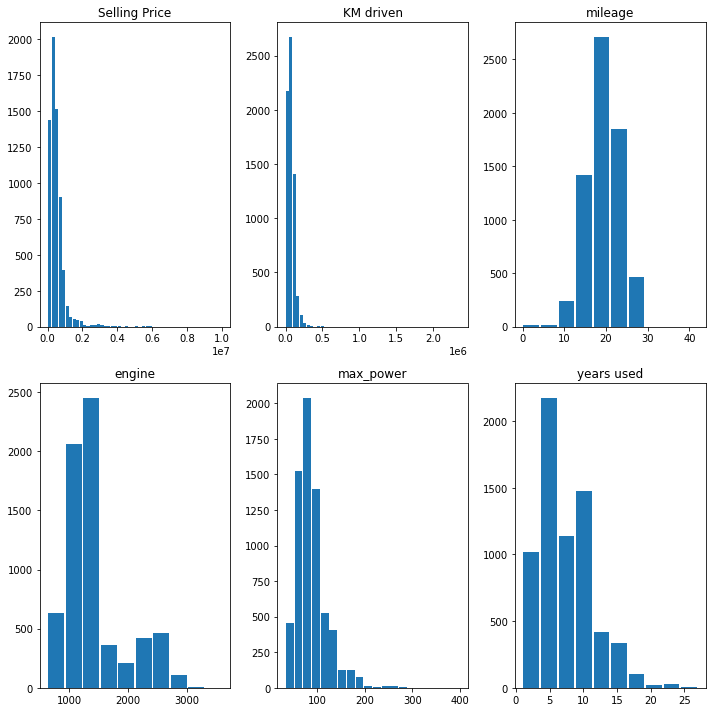

In [170]:
plt.figure(figsize= (10,10))
plt.subplot(2,3,1)
plt.title("Selling Price")
plt.hist(df.selling_price, rwidth = 0.9, bins=50)
plt.subplot(2,3,2)
plt.title("KM driven")
plt.hist(df.km_driven, rwidth = 0.9, bins = 50)
plt.subplot(2,3,3)
plt.title("mileage")
plt.hist(df.mileage, rwidth = 0.9)
plt.subplot(2,3,4)
plt.title("engine")
plt.hist(df.engine, rwidth = 0.9)
plt.subplot(2,3,5)
plt.title("max_power")
plt.hist(df.max_power, rwidth = 0.9, bins=20)
plt.subplot(2,3,6)
plt.title("years used")
plt.hist(df.years_used, rwidth = 0.9)
plt.tight_layout()


By observation, 
> selling_price, km_driven, max_power 
years_used seem to be right skewed


> mileage seems to be normally distributed


> engine seems to not follow any particular distributon










---
Boxplot for continuous variables


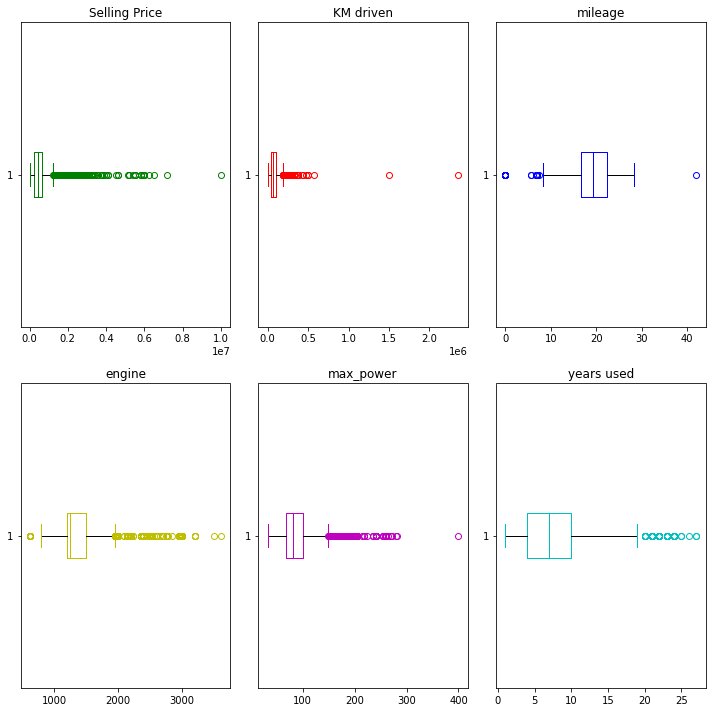

In [171]:
plt.figure(figsize= (10,10))
plt.subplot(2,3,1)
plt.title("Selling Price")
plt.boxplot(df.selling_price,
            boxprops=dict(color="g"),
            capprops=dict(color="g"),
            flierprops=dict(color='g', markeredgecolor='g'),
            medianprops=dict(color='g'),
            vert=False)
plt.subplot(2,3,2)
plt.title("KM driven")
plt.boxplot(df.km_driven,
            boxprops=dict(color="r"),
            capprops=dict(color="r"),
            flierprops=dict(color='r', markeredgecolor='r'),
            medianprops=dict(color='r'),
            vert=False)
plt.subplot(2,3,3)
plt.title("mileage")
plt.boxplot(df.mileage,
            boxprops=dict(color="b"),
            capprops=dict(color="b"),
            flierprops=dict(color='b', markeredgecolor='b'),
            medianprops=dict(color='b'),
            vert=False)
plt.subplot(2,3,4)
plt.title("engine")
plt.boxplot(df.engine,
            boxprops=dict(color="y"),
            capprops=dict(color="y"),
            flierprops=dict(color='y', markeredgecolor='y'),
            medianprops=dict(color='y'),
            vert=False)
plt.subplot(2,3,5)
plt.title("max_power")
plt.boxplot(df.max_power,
            boxprops=dict(color="m"),
            capprops=dict(color="m"),
            flierprops=dict(color='m', markeredgecolor='m'),
            medianprops=dict(color='m'),
            vert=False)
plt.subplot(2,3,6)
plt.title("years used")
plt.boxplot(df.years_used,
            boxprops=dict(color="c"),
            capprops=dict(color="c"),
            flierprops=dict(color='c', markeredgecolor='c'),
            medianprops=dict(color='c'),
            vert=False)
plt.tight_layout()


> km_driven, selling_price, mileage, max_power has very big outliers that is required to be dealt with



---
Visualising the categorical features VS demand


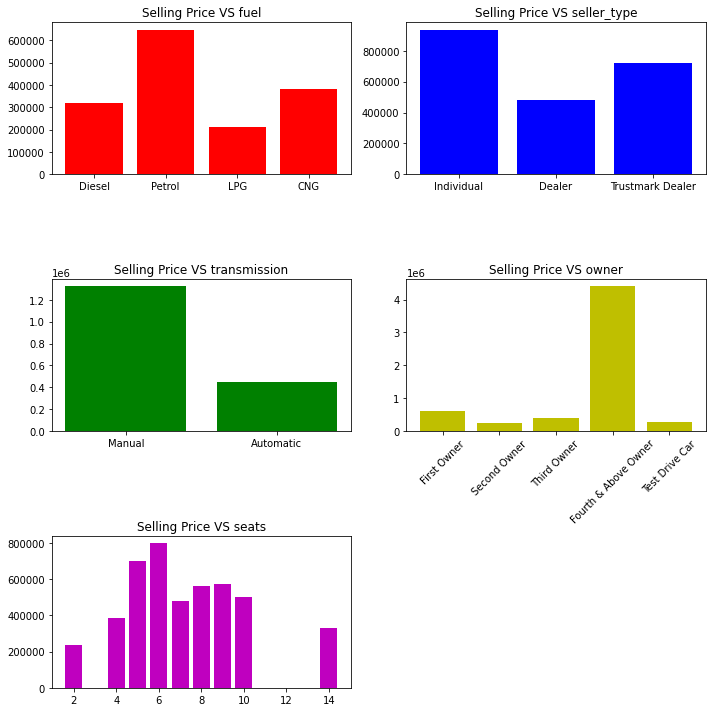

In [172]:
plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
plt.title("Selling Price VS fuel")
cat_unique = df.fuel.unique()
cat_average = df.groupby("fuel").mean()['selling_price']
plt.bar(cat_unique, cat_average, color="r")
plt.subplot(3,2,2)
plt.title("Selling Price VS seller_type")
cat_unique = df.seller_type.unique()
cat_average = df.groupby("seller_type").mean()['selling_price']
plt.bar(cat_unique, cat_average, color='b')
plt.subplot(3,2,3)
plt.title("Selling Price VS transmission")
cat_unique = df.transmission.unique()
cat_average = df.groupby("transmission").mean()['selling_price']
plt.bar(cat_unique, cat_average, color='g')
plt.subplot(3,2,4)
plt.title("Selling Price VS owner")
cat_unique = df.owner.unique()
cat_average = df.groupby("owner").mean()['selling_price']
plt.bar(cat_unique, cat_average, color='y')
plt.xticks(rotation=45)
plt.subplot(3,2,5)
plt.title("Selling Price VS seats")
cat_unique = df.seats.unique()
cat_average = df.groupby("seats").mean()['selling_price']
plt.bar(cat_unique, cat_average, color='m')
plt.tight_layout()

> All categorical variables show that there is variation for each category of a variable on selling price.

> All categorical variables are useful and should be kept.







In [173]:
continuous_lst = list(set(df.columns)-set(category_lst)-set(['torque','name']))
corr_table = df[continuous_lst].corr()
corr_table

,years_used,engine,km_driven,max_power,mileage,selling_price
years_used,1.000000,0.019763,0.387918,-0.159889,-0.366756,-0.427335
engine,0.019763,1.000000,0.253460,0.683506,-0.556946,0.442772
km_driven,0.387918,0.253460,1.000000,0.041770,-0.196344,-0.161265
max_power,-0.159889,0.683506,0.041770,1.000000,-0.354780,0.692323
mileage,-0.366756,-0.556946,-0.196344,-0.354780,1.000000,-0.096164
selling_price,-0.427335,0.442772,-0.161265,0.692323,-0.096164,1.000000


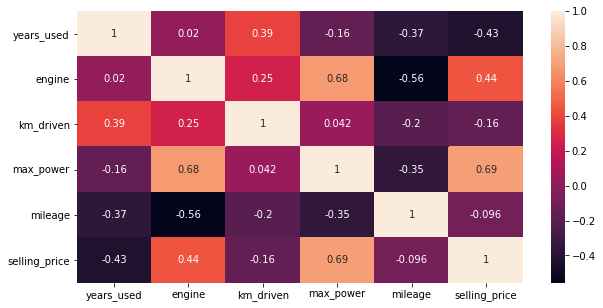

In [174]:
plt.figure(figsize=(10,5))
sns.heatmap(corr_table, annot = True)


> No signs of multicollinearity (>+-0.8) amongst our continous variables


> However mileage seem to have weak impact on selling_price - something to take note






#**Feature Selection and Engineering**

In [175]:
df.apply(lambda x: len(x.unique()), axis = 0)
df = df.drop(['name','torque'], axis=1) 



> Drop name and torque because they are categorical variables with too much variation - Not beneficial for building our model




In [176]:
description = df.describe()
description

,selling_price,km_driven,mileage,engine,max_power,years_used
count,6.717000e+03,6.717000e+03,6717.000000,6717.000000,6717.000000,6717.000000
mean,5.263860e+05,7.339834e+04,19.366707,1430.985857,87.766100,7.388864
std,5.235504e+05,5.870328e+04,4.069374,493.469198,31.724555,3.897402
min,2.999900e+04,1.000000e+00,0.000000,624.000000,32.800000,1.000000
25%,2.500000e+05,3.800000e+04,16.600000,1197.000000,67.100000,4.000000
50%,4.200000e+05,6.820300e+04,19.300000,1248.000000,81.830000,7.000000
75%,6.500000e+05,1.000000e+05,22.320000,1498.000000,100.000000,10.000000
max,1.000000e+07,2.360457e+06,42.000000,3604.000000,400.000000,27.000000


In [177]:
df.selling_price.quantile([0.003,0.5,0.75,0.997])

0.003      42000.0
0.500     420000.0
0.750     650000.0
0.997    4600000.0
Name: selling_price, dtype: float64

In [178]:
df.km_driven.quantile([0.003,0.5,0.75,0.997])

0.003      2158.2
0.500     68203.0
0.750    100000.0
0.997    300000.0
Name: km_driven, dtype: float64

In [179]:
df.mileage.quantile([0.003,0.5,0.75,0.997])

0.003     6.89
0.500    19.30
0.750    22.32
0.997    28.40
Name: mileage, dtype: float64

In [180]:
df.years_used.quantile([0.003,0.5,0.75,0.997])

0.003     1.0
0.500     7.0
0.750    10.0
0.997    23.0
Name: years_used, dtype: float64

In [181]:
df.max_power.quantile([0.003,0.5,0.75,0.997])

0.003     34.20
0.500     81.83
0.750    100.00
0.997    241.40
Name: max_power, dtype: float64

In [182]:
df.engine.quantile([0.003,0.5,0.75,0.997])

0.003     624.0
0.500    1248.0
0.750    1498.0
0.997    2993.0
Name: engine, dtype: float64

In [183]:
#selling_price
df = df.loc[df.selling_price<(6000000)]

#km_driven
df = df.loc[df.km_driven<(10**6)]

#years_used
df = df[(df.mileage<=(35)) & (df.mileage>=0)]

#max_power
df = df[df.max_power<350]

#engine
df = df.loc[df.engine<3000]

Dummy Encoding for categorical variables

In [184]:
df = pd.get_dummies(df, drop_first=True)

Scaling the Outcome Variable

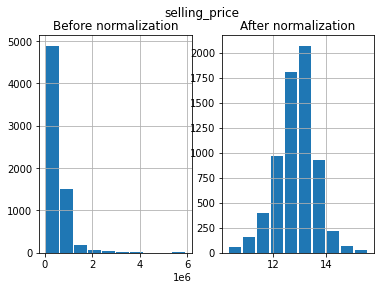

In [185]:
df_original = df.copy()
df1 = df['selling_price']
df2 = np.log(df1)
plt.figure()
plt.suptitle("selling_price")
plt.subplot(1,2,1)
plt.title("Before normalization")
df1.hist(rwidth=0.9)
plt.subplot(1,2,2)
plt.title("After normalization")
df2.hist(rwidth=0.9)
df['selling_price'] = np.log(df.selling_price)

# **Model Building**

Splitting into training and test dataset


In [186]:
from sklearn.model_selection import train_test_split
X = df.drop(['selling_price'], axis=1)
Y = df[['selling_price']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1234)


Multiple Linear Regression Model

In [187]:
from sklearn.linear_model import LinearRegression
std_reg = LinearRegression()
model = std_reg.fit(X_train, y_train)
y_predict = model.predict(X_test)

# **Validating model goodness and effectiveness**

Using k-fold cross validation to see if we have overfitted our data


In [188]:
from sklearn.model_selection import cross_val_score, cross_val_predict
scores = cross_val_score(model, X_train, y_train,cv=6)
print("Cross validated R^2 scores: ", scores)


Cross validated R^2 scores:  [0.84889004 0.85581735 0.837515   0.81979367 0.82355674 0.84302953]




> Generally all above 0.8, which is a good sign there is not overfitting



> This means that our model is good in predicing car prices accurately given outside data





We will gauge the metrics of the main model that we have built


In [189]:
r2_train = model.score(X_train, y_train)
r2_test = model.score(X_test,y_test)
adjusted_r_squared_train = 1 - (1-r2_train)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
adjusted_r_squared_test = 1 - (1-r2_test)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print("r2_train: ",round(r2_train,3),"\nr2_test: ",round(r2_test,3),"\n")
print("adjusted r2_train: ",round(adjusted_r_squared_train,3),"\nadjusted r2_test: ",round(adjusted_r_squared_test,3),"\n")


r2_train:  0.841 
r2_test:  0.849 

adjusted r2_train:  0.84 
adjusted r2_test:  0.848 





---

Normalzied RMSE 

In [190]:
from sklearn.metrics import mean_squared_error
y_test_lst = y_test['selling_price'].tolist()
y_predict_lst = list(map(lambda x: x[0], y_predict))
y_test_actual = []
y_predict_actual = []
for i in range(0,len(y_test)):
    y_test_actual.append(math.exp(y_test_lst[i]))
    y_predict_actual.append(math.exp(y_predict_lst[i]))
print("Minimum selling price: ", df_original.selling_price.min())
print("Maximum selling price: ",df_original.selling_price.max())
rmse = math.sqrt(mean_squared_error(y_test_actual, y_predict_actual))
normalized_rmse = rmse/(df_original.selling_price.max()-df_original.selling_price.min())
print(f'Normalized RMSE is {round(normalized_rmse,2)}')



Minimum selling price:  29999
Maximum selling price:  5923000
Normalized RMSE is 0.04


 ***Note:*
Had we removed the mileage feature, our adjusted r-squared would have been worse off, hence we kept in as one of our predictors

Proof:

In [191]:
X = df.drop(['selling_price','mileage'], axis=1)
Y = df[['selling_price']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1234)
std_reg = LinearRegression()
model = std_reg.fit(X_train, y_train)
y_predict = model.predict(X_test)
r2_train = model.score(X_train, y_train)
r2_test = model.score(X_test,y_test)
adjusted_r_squared_train = 1 - (1-r2_train)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
adjusted_r_squared_test = 1 - (1-r2_test)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print("adjusted r2_train: ",round(adjusted_r_squared_train,3),"\nadjusted r2_test: ",round(adjusted_r_squared_test,3),"\n")

adjusted r2_train:  0.838 
adjusted r2_test:  0.846 



### FINAL THOUGHTS AND CONCLUSION OF MODEL:

- We have obtained a good r2_test score of 0.849 AND a low NRMSE score of 0.02, and K-fold cross validation show no signs of overfitting
- In conclusion, this means that our model is a great fit for such a predicting car prices for the given metrics
- This means that target audience, mainly car buying/selling platform should find this analysis useful for pricing suggestions to 
sellers which makes prices more competitive and relevant, translating to higher sales rate, which results in better earnings 
for the company





---


**Notes for improvement
- Car sales are also dependent on time of the year, hence a model that include time series analysis can be included to gauge the
season where car is in higher demand->Charge higher prices OR lower demand-> Charge lower prices
- This dataset provides locale of only one country, hence model may or may not be applicable to all countries. Howeever, my belief
is that with simple fine tuning and feature seclection, this model will work equally well in different demographics
